# How the anorexic behavior of the browser is killing your site performance

Author: alcidesv@shimmercat.com

## Abstract

We want our websites to load faster, but just as an anorexic person who is unable to absorb nutrients at sufficient speed, the browser is unable to use the bandwidth it has available to fetch the website faster. In this study, we introduce the concept of data transfer density to measure the fraction of time in which the browser is receiving data from the network. Then we apply the measure to timing data from fetching almost 1300 sites, all of them submitted by performance-conscious operators. Our results show that for most sites the initial load of a web page uses the network very sparingly, at between 1/4 and 1/5 of the available capacity. 

## Notebook initialization and loading the dataset

In [1]:
%pylab
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

Using matplotlib backend: GTK3Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os.path
import json
import lzma
import re

In [3]:
 with lzma.open("data/clean_dataset.json.xz", 'rb') as fin:
    dataset_s = fin.read().decode('ascii')
    dataset = json.loads(dataset_s)

Number of data points
------------------------

That is, how many files there are in our little DB.

In [4]:
len(dataset)

1299

-----------------------------------------------

In [5]:
counts = pd.DataFrame( list( map( len, dataset ) ), columns=['asset_count'] )

In [6]:
counts[:5]

,asset_count
0,135
1,157
2,81
3,425
4,18


In [7]:
counts_clean = counts.query('asset_count > 5')
counts_clean['asset_count'].describe()

count    1218.000000
mean       85.719212
std        96.957801
min         6.000000
25%        25.000000
50%        54.000000
75%       108.000000
max       921.000000
Name: asset_count, dtype: float64

The number above should be used as our total of data-points: 
1233

----------------------

## When the first request can actually start

In [8]:
def extract_stoppers(entries_list):
    first_entry = entries_list[0]['timings']
    connect_time = first_entry['connect']
    dns_time = first_entry['dns']
    ssl = first_entry.get('ssl', 0)
    wait = first_entry.get('wait')
    return {
         'connect': connect_time,
         'dns': dns_time,
         'ssl': ssl,
         'wait': wait
        }

In [9]:
stoppers = list( map( extract_stoppers, dataset) )
stoppers_df = pd.DataFrame(stoppers)
stoppers_df[:5]

,connect,dns,ssl,wait
0,248.055,410.190000,215.08,35.995999
1,44.974,192.953000,-1.00,275.657000
2,166.749,182.938000,-1.00,166.886000
3,8.034,246.746000,-1.00,123.576000
4,24.032,1.269001,-1.00,30.242000


In [10]:
stoppers_df_clean = stoppers_df.query('connect > 0')
stoppers_df_clean[:5]

,connect,dns,ssl,wait
0,248.055,410.190000,215.08,35.995999
1,44.974,192.953000,-1.00,275.657000
2,166.749,182.938000,-1.00,166.886000
3,8.034,246.746000,-1.00,123.576000
4,24.032,1.269001,-1.00,30.242000


### How the bare connection times are distributed

This does not include DNS or SSL times

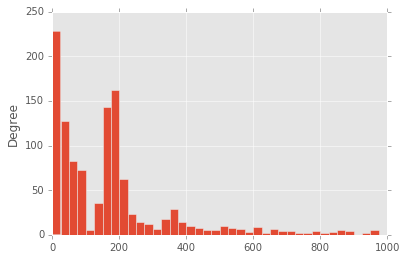

In [11]:
stoppers_df_clean['connect'].plot(kind='hist', bins=np.arange(0,1000,25))

≽ There seems to be two modes. My guess for those are some sites are in EE.UU. (same place where the browser that made the measurements is located) and som are in Europe.

### How the total times are distributed for connections without SSL

In [12]:
stoppers_nossl_clean = stoppers_df_clean.query('ssl == -1')
stoppers_nossl_clean[:5]

,connect,dns,ssl,wait
1,44.974,192.953000,-1,275.657
2,166.749,182.938000,-1,166.886
3,8.034,246.746000,-1,123.576
4,24.032,1.269001,-1,30.242
8,175.758,455.540000,-1,232.651


In [13]:
full_nossl_stoppers = (
    stoppers_nossl_clean['connect']+stoppers_nossl_clean['dns']
)
full_nossl_stoppers[:5]

1    237.927
2    349.687
3    254.780
4     25.301
8    631.298
dtype: float64

In [14]:
full_nossl_stoppers.describe()

count     766.000000
mean      308.352056
std       316.510355
min         1.459000
25%        90.990000
50%       219.612500
75%       403.744750
max      2595.431000
dtype: float64

### How the total times are distributed for connections with SSL

In [15]:
stoppers_ssl_clean = stoppers_df_clean.query('ssl > 0')
stoppers_ssl_clean[:5]

,connect,dns,ssl,wait
0,248.055000,410.190,215.080,35.995999
5,338.042000,0.783,171.889,583.673000
6,364.349999,547.143,192.664,172.649000
7,74.965999,33.080,66.908,51.791000
9,26.235000,1.444,19.094,31.299000


#### SSL connection time

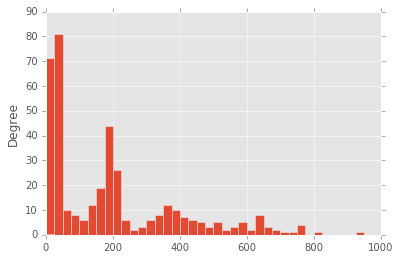

In [16]:
stoppers_ssl_clean['ssl'].plot(kind='hist', bins=np.arange(0,1000,25))

In [17]:
stoppers_ssl_clean['ssl'].describe()

count     388.000000
mean      213.935379
std       296.875515
min         9.387000
25%        32.193000
50%       157.536500
75%       313.120250
max      3979.796000
Name: ssl, dtype: float64

#### All the time that clients communicating via SSL need to wait before issuing the first request

In [18]:
full_stoppers = (
    stoppers_ssl_clean['ssl']+stoppers_ssl_clean['connect']+stoppers_ssl_clean['dns']
)
full_stoppers[:5]

0     873.325001
5     510.714000
6    1104.157000
7     174.954000
9      46.773000
dtype: float64

In [19]:
full_stoppers.describe()

count     388.000000
mean      673.190067
std       765.692759
min        36.078000
25%       113.160000
50%       513.419000
75%       969.809500
max      8416.813000
dtype: float64

That is, the mean time is well over half a second.The difference of mean with the connections that don't use SSL is 673 - 459 = 214, very close to the mean SSL connection time.

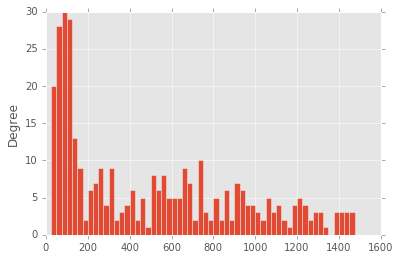

In [20]:
full_stoppers.plot(kind='hist', bins=np.arange(0,1500,25))

## How much remains unused

This section explores which part of the loading time of web pages goes empty, meaning that no data is being received by the browser.

### Sets of intervals

The idea here is that it is possible to construct an interval that goes from the time when the first byte for a response to a request is received and then goes until when the last byte for that response is received. We know with security that during this time interval, the browser is receiving data. 

Then we want to research the *data transfer density*. We can express this concept as follows: if a chronometer is started as soon as the **first byte from the server is received**, and stopped at any ulterior point, the data transfer density is the probability at that point in time of the browser to be receiving data required to render the page via the network. Notice that we don't include the stoppers time we detailed before, nor the waiting time for the data on the response to the first request. Therefore, an ideal page load would be one where the data transfer density is very close to one at the beginning, and then abruptly drops to zero when the page is done loading. In practice this doesn't happen because the browser discovers which assets it needs incrementally.

In order to compute the data transfer density, we have to merge the times interval corresponding to each response, taking into account that data for multiple responses can be coming in parallel.

In [21]:
def merge_sets_step(s1):

    # Take the first interval
    fi = s1[0]
    fi_start, fi_end = fi 
    r_start = fi_start
    r_end = fi_end
    # Take the other intervals, and see if we can merge them
    for (_i,ai) in enumerate(s1[1:]):
        ai_start, ai_end = ai 
        if ai_start <= r_end:
            # A merge is possible 
            r_end = ai_end 
        else:
            # A merge is not possible. Since the intervals 
            # are sorted by their starting point, the next 
            # interval will start at a more distant place. 
            # Finish by returning the new merged big interval
            # and the rest of the sorted set.... 
            return ((r_start, r_end), s1[_i+1:])
    # If I arrive here, it is just a big one
    return ((r_start, r_end), [])

def merge_interval_sets(iterable_of_intervals):
    # Sort the intervals ... 
    s1 = sorted(iterable_of_intervals, key=(lambda i: i[0]))
    si = s1
    disjoint_intervals = []
    disjoint_voids = []
    mi_end_prev = None
    while len(si) > 0:
        (merged_interval, si_next) = merge_sets_step(si)
        mi_start, mi_end = merged_interval
        if mi_end_prev:
            disjoint_voids.append((mi_end_prev, mi_start))
        mi_end_prev = mi_end
        disjoint_intervals.append(merged_interval)
        si = si_next
    return (disjoint_intervals, disjoint_voids)

Let's just test a little bit the merge intervals function.

In [22]:
merge_sets_step([
        (0,1),
        (2,3)
    ])

((0, 1), [(2, 3)])

In [23]:
merge_sets_step([
        (0,1),
        (0.5,1.5),
        (2,3)
    ])

((0, 1.5), [(2, 3)])

In [24]:
merge_sets_step([
        (0,1),
        (0.5,2.5),
        (2,3)
    ])

((0, 3), [])

In [25]:
merge_interval_sets([
        (0,1),
        (0.5,2.5),
        (2,3)
    ])

([(0, 3)], [])

In [26]:
merge_interval_sets([
        (0,1),
        (0.5,1.5),
        (2,3),
        (3,4),
        (4.01, 6)
    ])

([(0, 1.5), (2, 4), (4.01, 6)], [(1.5, 2), (4, 4.01)])

Looks good, let's continue.

### Parsing the date-times

This is how the starting times of a request look in the jar file.

In [27]:
dtsample = dataset[0][0]['startedDateTime']
dtsample

'2015-12-01T08:37:30.598Z'

Python datetime function is unable to directly parse this type of data, so let's just do it by hand...

In [28]:
rgx_ = re.compile( 'T([0-9]{2}):([0-9]{2}):([0-9]{2}\.[0-9]*)Z' )
ms_ = 1000
def dt2milliseconds(dtval):
    mo = re.search(rgx_, dtval)
    milliseconds = \
       int( mo.group(1) )*3600*ms_ + \
       int( mo.group(2) )*60*ms_ + \
       float( mo.group(3) )*ms_
    return milliseconds

### Deducing the intervals from the timings

Using the 'timings' key in the dataset entries, and the started time, let's deduce an interval as a tuple with the start and end time in milliseconds.

In [29]:
def deduce_interval_optimistic(timings, starts_dtval):
    # Uses the timings entry in each fetch and its starting time 
    # to deduce a set of "inhabited" intervals and a set of 
    # "populated" intervals. 
    mseconds_start = dt2milliseconds(starts_dtval)
    connect = timings.get('connect',0)
    dns = timings.get('dns', 0)
    blocked = timings.get('blocked', 0)
    # Chrome uses '-1' to signal that the timing doesn't apply
    if connect < 0:
        connect = 0
    if dns < 0: 
        dns = 0
    ssl = timings.get('ssl', 0)
    if ssl < 0:
        ssl = 0
    send = timings.get('send')
    wait = timings.get('wait')
    receive = timings.get('receive')
    
    starts_receiving = mseconds_start + connect + dns + ssl + send + wait
    ends_receiving = starts_receiving + receive
    return (starts_receiving, ends_receiving)

The function below takes all the intervals, merges and summarizes them. However, instead of looking to the time when data is being received, we look to the part when data is **not** being received. We call those intervals when the browser is not receiving data from the network, *voids*.

In [30]:
def summarize_intervals_from_entries(entries):
    # Function to return a Pandas' data frame with all the 
    # intervals in the file, after merging them.
    #
    if len(entries) <= 2:
        return None
    # returns a data frame with the void times, their lengths, 
    # the void_end and so so...
    all_file_intervals = [
        deduce_interval_optimistic(entry['timings'], entry['startedDateTime'])
        for entry in entries
    ]
    # Two sets of complimentary, non overlapping intervals. 
    # The first set (non overlapping) intervals represents when data is being received 
    # from the server. The second set  represents when no data is being received.
    data_traffic_intervals, void_intervals = merge_interval_sets(all_file_intervals)
    # zero: when the first byte of data of a response. That is, it doesn't
    # count the first wait that the browser did. 
    zero = data_traffic_intervals[0][0]
    # How much time not-data has been received.
    cumulative_void = 0
    # How much total time data has been received 
    cumulative_full = 0
    idata = []
    for y in void_intervals:
        a,b = y
        if a - zero > 4000:
            break
        cumulative_void += (b - a)
        void_start = a - zero
        void_end = b - zero
        unused_time_proportion = cumulative_void / void_end
        idata.append({
            'unused_prop': unused_time_proportion,
            'void_start': void_start, 
            'void_length': b - a,
            'void_end': void_end,
            'total_void': cumulative_void, 
            'dtd': 1 - unused_time_proportion
        })
    idata_df = pd.DataFrame( 
        idata , 
        columns=['void_start', 'void_length', 'void_end', 'total_void', 'unused_prop', 'dtd']
    )
    return idata_df

This is how it looks for a single entry in the dataset:

In [31]:
file_entries = dataset[0]
summary = summarize_intervals_from_entries(file_entries)
summary[:5]

,void_start,void_length,void_end,total_void,unused_prop,dtd
0,1.702937,5.798064,7.501001,5.798064,0.772972,0.227028
1,7.887998,6.815003,14.703001,12.613066,0.857857,0.142143
2,15.480956,5.445044,20.926000,18.058110,0.862951,0.137049
3,23.287823,0.886178,24.174001,18.944289,0.783664,0.216336
4,26.569071,0.635930,27.205001,19.580219,0.719729,0.280271


In the table above, the variable `unused_prop` represents the complement of the data transfer density. That is, the higher `unused_prop`, the lowest the data transfer density. 

## Calculating and summarizing the void time for all the points of the sample

We are going to calculate the data transfer density at the boundary of every void. To have a way to compare data transfer density from different sites in the data set, we are going to roughly estimate which of those boundaries correspond to 1/10 fractions of the load. Then we are going to summarize the data transfer density at those points.

In [32]:
# Returns some quantiles. The quantiles are 
# in the "request no" axis, that is, the 25% percentile
# shows the situation when 25% of the requests for that 
# particular entries file has been processed. 
quantile_labels = ["quant {0:0.2f}".format(ff) for ff in np.linspace(0,1,11)][:-1]
def void_time_quantiles(summary):
    entry_count = summary.index.shape[0]
    if entry_count < 10:
        return None
    sample_indices = np.floor( np.linspace(0, entry_count, 11)[:-1] ).astype(int)
    #print(entry_count, sample_indices)
    quantiles = summary['dtd'].irow(sample_indices)
    row=dict(zip(quantile_labels, quantiles))
    return row

In [33]:
quantile_list = []
for entries in dataset:
    entry_summary = summarize_intervals_from_entries(entries)
    if entry_summary is None:
        continue
    quantiles = void_time_quantiles(entry_summary)
    if quantiles is None:
        continue
    quantile_list.append(quantiles)
quantiles_pd = pd.DataFrame(quantile_list)

In [34]:
quantiles_pd.describe(percentiles=[0.0, 0.05, 0.1, 0.25, 0.50, 0.75, 0.90, 0.95])

,quant 0.00,quant 0.10,quant 0.20,quant 0.30,quant 0.40,quant 0.50,quant 0.60,quant 0.70,quant 0.80,quant 0.90
count,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000,1101.000000
mean,0.278473,0.250387,0.239418,0.224830,0.217749,0.213495,0.207442,0.200875,0.195608,0.193806
std,0.351126,0.240736,0.200258,0.175801,0.162672,0.151610,0.145255,0.136118,0.131622,0.131339
min,0.000000,0.000000,0.000000,0.002871,0.002500,0.002673,0.002849,0.003159,0.003263,0.003421
0%,0.000000,0.000000,0.000000,0.002871,0.002500,0.002673,0.002849,0.003159,0.003263,0.003421
5%,0.000712,0.004631,0.012584,0.020486,0.026690,0.027179,0.029422,0.035859,0.033478,0.035887
10%,0.001411,0.009360,0.027494,0.038044,0.050076,0.048941,0.052031,0.057036,0.056733,0.056729
25%,0.005717,0.048936,0.088017,0.098551,0.103329,0.104191,0.104796,0.106048,0.103705,0.101988
50%,0.053502,0.184165,0.188132,0.177747,0.174789,0.176399,0.175680,0.172963,0.167871,0.162186
75%,0.536754,0.382694,0.345476,0.313934,0.298128,0.288112,0.272630,0.260573,0.251535,0.252236


## Shimmercat data

It is possible to achieve a higher data transfer density with [ShimmerCat](https://www.shimmercat.com). With minimal effort, our site and server achieves dtd values between 0.70 and 0.93. Compare with the data in the previous table.

In [ ]:
entries_shimmercat = json.load(open("data/www.shimmercat.com.har"))['log']['entries']

In [ ]:
summarize_intervals_from_entries(entries_shimmercat)